In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import toydata
from feature_adaptation.jda import JDA
from feature_adaptation.vda import VDA
from feature_adaptation.tca import TCA

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
def get_mmd(P, Q, metric = 'linear', **kwargs):
    n1 = P.shape[0]
    n2 = Q.shape[0]
    #n = n1 + n2
    X = np.vstack((P, Q))
    K = pairwise_kernels(X, metric = metric, filter_params = True, **kwargs)
    a = 1.0 / (n1 * np.ones((n1, 1)))
    b = -1.0 / (n2 * np.ones((n2, 1)))
    e = np.vstack((a, b))
    L = np.dot(e, e.T)
    return np.trace(np.dot(K, L))

In [3]:
def swap_label(y):
    y_swap = np.zeros(len(y))
    uni_label = np.unique(y)
    y_swap[y==uni_label[0]] = uni_label[1]
    y_swap[y==uni_label[1]] = uni_label[0]
    return y_swap

def evaluate(pred, y):
    pred_ = swap_label(pred)
    if accuracy_score(y, pred)>accuracy_score(y, pred_):
        return accuracy_score(y, pred)
    else:
        return accuracy_score(y, pred_)

In [4]:
random_state = 10

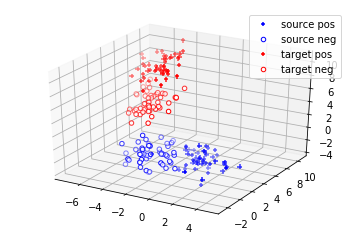

MMD:  84.15104914456963


In [5]:
Xs, ys, Xt, yt = toydata.get_toydata(n_features = 3, mismatch = 'joint')
y_all = np.hstack((ys, yt))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs[np.where(ys==np.unique(ys)[1])][:, 0], Xs[np.where(ys==
                 np.unique(ys)[1])][:, 1], Xs[np.where(ys==
                 np.unique(ys)[1])][:, 2], marker='+', c='b', label = 'source pos')
ax.scatter(Xs[np.where(ys==np.unique(ys)[0])][:, 0], Xs[np.where(ys==
                 np.unique(ys)[0])][:, 1], Xs[np.where(ys==
                 np.unique(ys)[0])][:, 2], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
ax.scatter(Xt[np.where(yt==np.unique(ys)[1])][:, 0], Xt[np.where(yt==
                 np.unique(ys)[1])][:, 1], Xt[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
ax.scatter(Xt[np.where(yt==np.unique(ys)[0])][:, 0], Xt[np.where(yt==
                 np.unique(ys)[0])][:, 1], Xt[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')

plt.legend()
plt.show()

print('MMD: ',get_mmd(Xs, Xt))

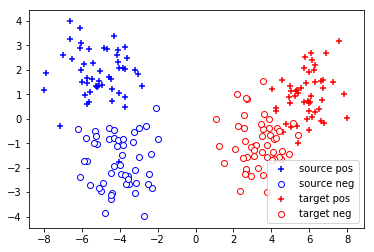

MMD: 84.0823933633385


In [6]:
pca = PCA(n_components = 2)
pca.fit(np.vstack((Xs, Xt)))
Xs_pc = pca.transform(Xs)
Xt_pc = pca.transform(Xt)

plt.scatter(Xs_pc[np.where(ys==np.unique(ys)[1])][:, 0], Xs_pc[np.where(ys==
                 np.unique(ys)[1])][:, 1], marker='+', c='b', label = 'source pos')
plt.scatter(Xs_pc[np.where(ys==np.unique(ys)[0])][:, 0], Xs_pc[np.where(ys==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
plt.scatter(Xt_pc[np.where(yt==np.unique(ys)[1])][:, 0], Xt_pc[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
plt.scatter(Xt_pc[np.where(yt==np.unique(ys)[0])][:, 0], Xt_pc[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')

plt.legend()
plt.show()

print('MMD: %s'%get_mmd(Xs_pc, Xt_pc))

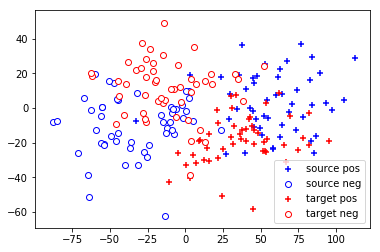

Clustering accuracy: 0.91
Classification accuracy:  0.79
MMD: 0.0010399225258750366


In [7]:
#TCA
my_tca = TCA(2, kernel='linear', lambda_ = 10)

Xtcs, Xtct = my_tca.fit_transform(Xs, Xt)

plt.scatter(Xtcs[np.where(ys==np.unique(ys)[1])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[1])][:, 1], marker='+', c='b', label = 'source pos')
plt.scatter(Xtcs[np.where(ys==np.unique(ys)[0])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
plt.scatter(Xtct[np.where(yt==np.unique(ys)[1])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
plt.scatter(Xtct[np.where(yt==np.unique(ys)[0])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')

plt.legend()
plt.show()

y_pred = KMeans(n_clusters=2,
                random_state=random_state).fit_predict(np.vstack((Xtcs, Xtct)))
res = evaluate(y_pred, y_all)
print('Clustering accuracy: %s'%res)

clf = SVC(kernel='linear')
clf.fit(Xtcs, ys)

print('Classification accuracy: ',accuracy_score(yt, clf.predict(Xtct)))
print('MMD: %s'%get_mmd(Xtcs, Xtct))

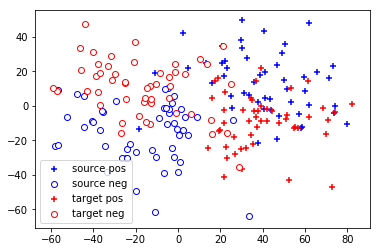

Clustering accuracy: 0.93
Classification accuracy: 0.86
MMD: 3.973352837597808


In [8]:
#JDA
my_jda = JDA(2, kernel_type='linear', lambda_ = 1)
ZZs, ZZt = my_jda.fit_transform(Xs, Xt, ys, yt)

plt.scatter(ZZs[np.where(ys==np.unique(ys)[1])][:, 0], ZZs[np.where(ys==
                 np.unique(ys)[1])][:, 1], marker='+', c='b', label = 'source pos')
plt.scatter(ZZs[np.where(ys==np.unique(ys)[0])][:, 0], ZZs[np.where(ys==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
plt.scatter(ZZt[np.where(yt==np.unique(ys)[1])][:, 0], ZZt[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
plt.scatter(ZZt[np.where(yt==np.unique(ys)[0])][:, 0], ZZt[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')


plt.legend()
plt.show()

y_pred = KMeans(n_clusters=2,
                random_state=random_state).fit_predict(np.vstack((ZZs, ZZt)))
res = evaluate(y_pred, y_all)
print('Clustering accuracy: %s'%res)

clf.fit(ZZs, ys)
print('Classification accuracy: %s'%accuracy_score(yt, clf.predict(ZZt)))
print('MMD: %s'%get_mmd(ZZs, ZZt))

In [9]:
from model_adaptation.cdsvm_cvxpy import CDSVM

src_clf = SVC(kernel='linear')
src_clf.fit(Xtcs, ys)
cdsvm = CDSVM(src_clf.support_vectors_, ys[src_clf.support_])
cdsvm.fit(Xtct, yt)

svm =  SVC(kernel='linear')
svm.fit(np.vstack((Xtcs, Xtct)), np.hstack((ys, yt)))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

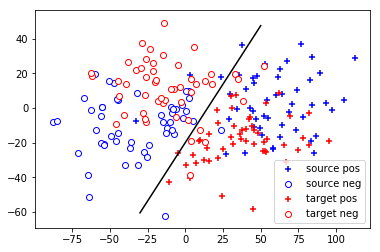

In [10]:
# plot svm decision boundary
w = svm.coef_[0]
xx = np.linspace(-30, 50)
a = -w[0] / w[1]
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.scatter(Xtcs[np.where(ys==np.unique(ys)[1])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[1])][:, 1], marker='+', c='b', label = 'source pos')
plt.scatter(Xtcs[np.where(ys==np.unique(ys)[0])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
plt.scatter(Xtct[np.where(yt==np.unique(ys)[1])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
plt.scatter(Xtct[np.where(yt==np.unique(ys)[0])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')

plt.plot(xx, yy, 'k-')
plt.legend()
plt.show()

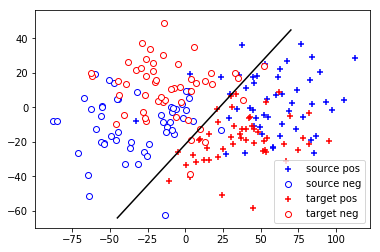

In [11]:
# plot cdsvm decision boundary
w = cdsvm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-45, 70)
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.scatter(Xtcs[np.where(ys==np.unique(ys)[1])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[1])][:, 1], marker='+', c='b', label = 'source pos')
plt.scatter(Xtcs[np.where(ys==np.unique(ys)[0])][:, 0], Xtcs[np.where(ys==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'b',
            label = 'source neg')
plt.scatter(Xtct[np.where(yt==np.unique(ys)[1])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[1])][:, 1], marker='+', c='r', label = 'target pos')   
plt.scatter(Xtct[np.where(yt==np.unique(ys)[0])][:, 0], Xtct[np.where(yt==
                 np.unique(ys)[0])][:, 1], marker='o', c='w', edgecolors = 'r',
            label = 'target neg')

plt.plot(xx, yy, 'k-')
plt.legend()
plt.show()